In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from stargazer.stargazer import Stargazer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
data = pd.read_csv('kickers_v2.csv')

In [4]:
data.head()

,Unnamed: 0,Team,Year,GameMinute,Kicker,Distance,ScoreDiff,Grass,Success
0,1,PHI,2005,3,Akers,49,0,False,0
1,2,PHI,2005,29,Akers,49,-7,False,0
2,3,PHI,2005,51,Akers,44,-7,False,1
3,4,PHI,2005,14,Akers,43,14,True,0
4,5,PHI,2005,60,Akers,23,0,True,1


In [5]:
# It's important we check for NAN before we start our analysis.
data.isnull().values.any()

False

<h1> PSET 1 Econ 1042 Sports Economics </h1>
<h2> 1. Question </h2>
<ol>
    <li> What was the minimum distance of a field goal kicked in this sample? What was the maximum? Mean? Median!</li>
    <li> Why isn’t the minimum lower? (For those who are not familiar with football, please read about how field goal distance is measured and its relationship to where the ball is on the field.)</li>
    <li> What special circumstances might explain the maximum? (Hint: football is a game with 4, 15-minute quarters. At the end of the second quarter there is a halftime break and possession is assigned based on the result of a first-half coin toss) </li>
</ol>

In [6]:
print(f"The median distance of a field goal kicked was {np.median(data['Distance'])}")
data['Distance'].describe()

The median distance of a field goal kicked was 37.0


count    11187.000000
mean        36.897381
std         10.173351
min         18.000000
25%         28.000000
50%         37.000000
75%         45.000000
max         76.000000
Name: Distance, dtype: float64

1. The minimum distance of a field goal kicked in the sample was 18.00 yards. The maximum was 76.00 yards and the median was 37.0 yards. The mean was 36.897 yards
2. The minimum is 17 yards. This makes sense since the endzone is 10yards, and the ball has to be kicked from 7 yards from the line of scrimmage. Hence 10 + 7 = 17.

In [7]:
# Lets find out what play was kicked from 76 yards away?
max_yard = data.loc[data['Distance'] == 76.00]
max_yard

,Unnamed: 0,Team,Year,GameMinute,Kicker,Distance,ScoreDiff,Grass,Success
3557,3558,OAK,2008,30,Janikowski,76,15,True,0


3. The 76 yards field goal attempt from Janikowski was in the last second of the second quarter (video: https://www.youtube.com/watch?v=X7BepDe6Zoc). It makes sense to kick if far into the opponents end zone, if in the first half your team had the ball. Since, then the opposing team will start from further away from the kickers endzone. It's like as if the special team does a punt.

<h2> 2. Question </h2>
<p> Over the entire sample what percentage of kicks from 40 to 45 yards were made? Kicks over 45 yards? <p>

In [8]:
sample_size = len(data)
# let's find the number of successful kicks from 40-45 yards
kicks_40_45 = data.loc[(data['Distance'] > 40) & (data['Distance'] < 45)]
# We find that 1325 kicks were made in that range
success_40_45 = kicks_40_45['Success'].value_counts()
# print(success_40_45)
ratio_success = success_40_45[1]/(success_40_45[0] + success_40_45[1])
ratio = (len(kicks_40_45)/sample_size) * 100
print(f'{ratio:.3f}% of Kicks were from between 40-45 yards')

# How many kicks were over 45 yards?
# kicks

11.844% of Kicks were from between 40-45 yards


In [9]:
kicks_above_45 = data.loc[data['Distance'] > 45]
ratio_above_45 = (len(kicks_above_45)/sample_size) * 100
print(f'{ratio_above_45:.3f}% of Kicks were from between 40-45 yards')

24.439% of Kicks were from between 40-45 yards


<h2> 3. Question </h2>
<p> Was the make rate higher on grass or on turf? Is that difference statistically significant? Do you think this is the true effect of surface? Why or why not?  (Answer this by doing an OLS regression. For the entire assignment, let’s use the heteroskedasticity robust standard errors, r in stata or the equivalent in R)<br> <br>
Let's compute the difference using $\Delta = \bar{Y}_{grass} - \bar{Y}_{turf}$ we shall report standard errors as heteroscedasticity robust (HC2) 
</p>

In [10]:
# define response variable
# statsmodel requires us to add a column where each value is 1 in order to compute intercept
data['Intercept'] = 1
# Since we find no NAN in our column
print(data['Grass'].isnull().values.any())
# We can conver the 'bool' values for Grass to the datatype 'int'
data['Grass'] = data['Grass'].astype(int)
Y = data[['Success']]
X = data[['Grass', 'Intercept']]
mod = sm.OLS(Y, X)
res = mod.fit(cov_type='HC2')
print(res.summary())

False
                            OLS Regression Results                            
Dep. Variable:                Success   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.500
Date:                Wed, 01 Feb 2023   Prob (F-statistic):            0.00618
Time:                        21:59:23   Log-Likelihood:                -4845.9
No. Observations:               11187   AIC:                             9696.
Df Residuals:                   11185   BIC:                             9710.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Grass         -0.0193      0.007     -2.739   

In [11]:
# Let's also try the Sklearn Library
# We can also use the Sklearn Library to do an OLS regression, but I don't think it has a summary function.
X = data[['Grass']]
reg = LinearRegression(fit_intercept=True).fit(X,Y)
parameters = reg.get_params()
print(reg.coef_[0][0])

-0.019329247569502543


We find that the observed difference is statistically insignificant at the $\alpha = 0.05$ level. It seems as if the surface does not have an impact on the observed average success rates of field goal kicks.

<h2> 4. Question </h2>
<ol>
    <li>	How is distance of attempt correlated with surface? What might explain this? (Coaches get to choose when to kick a field goal, one is never forced) </li>
    <li> 	How is distance correlated with make percentage? </li>
</ol>

In [12]:
# Let's calculate the correlation between the columns
corr_surface = data['Distance'].corr(data['Grass'])
corr_success = data['Distance'].corr(data['Success'])
print(corr_surface)
print(corr_success)

-0.002551996001227438
-0.33693399701495164


The correlation coefficient for distance and or Grass is -0.0025, basically negligible. The correlation coefficiecnt for distance and success rates is -0.3369, meaning as distance increases the success rate goes down. 

<h2> 5. Question </h2>
<ol>
    <li>What is the formula for omitted variable bias?</li>
    <li>Given (a) what should happen to the estimate of the effect of a kick being on grass when you add in distance? Verify this is true.</li>
</ol>

1. Ommitted variable bias arises when the regressor X is correlated with an omitted variable.
The formula for omitted variable bias is <br>$\hat{\beta}_{1,OLS}= \frac{Cov(y,x_1)}{Var(x_1)}$
2. Since distance and grass are negatively correlated as well as distance and success rate our estimate from the short regression will be positively biased. Ultimately, revealing that kicking on grass is harder then on turf.

In [13]:
Y = data[['Success']]
X = data[['Grass', 'Distance', 'Intercept']]
mod = sm.OLS(Y, X)
res = mod.fit(cov_type='HC2')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Success   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     695.7
Date:                Wed, 01 Feb 2023   Prob (F-statistic):          1.74e-285
Time:                        21:59:23   Log-Likelihood:                -4171.1
No. Observations:               11187   AIC:                             8348.
Df Residuals:                   11184   BIC:                             8370.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Grass         -0.0200      0.007     -3.004      0.0

In [14]:
mod = smf.ols(formula='Success ~ Grass + Distance', data=data).fit(cov_type='HC2')
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                Success   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     695.7
Date:                Wed, 01 Feb 2023   Prob (F-statistic):          1.74e-285
Time:                        21:59:23   Log-Likelihood:                -4171.1
No. Observations:               11187   AIC:                             8348.
Df Residuals:                   11184   BIC:                             8370.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2999      0.011    115.413      0.0

In [15]:
data.columns

Index(['Unnamed: 0', 'Team', 'Year', 'GameMinute', 'Kicker', 'Distance',
       'ScoreDiff', 'Grass', 'Success', 'Intercept'],
      dtype='object')

<h2> 6. Question </h2>
<ol>
    <li> Run an ols regression of kick success on distance, surface, point differential, and clock time. Interpret the coefficients. Does it seem like kickers do better or worse late in the game? Does the score of the game seem to effect them?</li>

<li>Now add in kicker fixed effects (i.kicker in Stata), what do these correct for? How does adjusted r-squared change? </li>
</ol>

In [16]:
mod = smf.ols(formula='Success ~ Distance + Grass + ScoreDiff + GameMinute', data=data).fit(cov_type='HC2')
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                Success   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     347.8
Date:                Wed, 01 Feb 2023   Prob (F-statistic):          1.07e-282
Time:                        21:59:23   Log-Likelihood:                -4171.0
No. Observations:               11187   AIC:                             8352.
Df Residuals:                   11182   BIC:                             8389.
Df Model:                           4                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2987      0.013    101.462      0.0

<p>1. The Game minute seems to have no statistically significant effect on Kicker performance. Furthermore, the point differential of the game does not seem to be statistically significant either, and also not affect kicker success rates.</p>

In [17]:
mod = smf.ols(formula='Success ~ Distance + Grass + ScoreDiff + GameMinute + C(Kicker)', data=data).fit(cov_type='HC2')
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                Success   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                 8.581e+10
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:59:23   Log-Likelihood:                -4088.0
No. Observations:               11187   AIC:                             8350.
Df Residuals:                   11100   BIC:                             8987.
Df Model:                          86                                         
Covariance Type:                  HC2                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 86, but rank is 85
  warnings.warn('covariance of constraints does not have full '


<p> 2. Adjusted R-square goes up, since we adjusting our regression for individuals attributes that do not vary over the time of a season.

<h2> 7. Question </h2>
<ol>
    <li> After you run the regression in part 6, do the command to predict fitted values from this regression: “predict, xb” in stata and equivalent in R “predict.lm”. Based on this, what would you predict the probability of Justin Tucker cutting the lead to 8 (scorediff was -11) in 2015, when the gameminute was 30, and he was on turf</li>
    <ol>
        <li> We can't build a model using all inputs, and then try to predict sth when missing one value. Missing here is an input for the <strong>Distance.</strong> Hence we must find it ourselves in the data.</li>
    </ol>

<li>Does this estimate strike you as reasonable?</li>
<li>What would the estimate be for an average kicker?</li>
</ol>

In [18]:
data_tucker = data.loc[data['Kicker'] == 'Tucker']
X = data_tucker[['Intercept', 'Distance', 'Grass', 'ScoreDiff', 'GameMinute']]
Y = data_tucker[['Success']]
reg_ols_tucker = sm.OLS(Y,X).fit(cov_type='HC2')
reg_ols_tucker.predict([1,30, False, -11, 30])

array([0.93507468])

In [19]:
# Let's use the Sklearn library for this prediction. Since we can specify the input.
# Since we are interested in Tucker
data_tucker = data.loc[data['Kicker'] == 'Tucker']
X = data_tucker[['Distance', 'Grass', 'ScoreDiff', 'GameMinute']]
Y = data_tucker[['Success']]
reg = LinearRegression(fit_intercept=True).fit(X,Y)
parameters = reg.get_params()
# Let's find the distance of the kick from tucker with scroediff -11, gameminute 30, and on turf
tucker = data_tucker.loc[(data_tucker['ScoreDiff']==-11)&(data_tucker['GameMinute']==30) & (data_tucker['Grass']==False)]
tucker

reg_coef = list(np.ravel(reg.coef_))
reg_coef.insert(0, 'Linear_Tucker')
proba = reg.predict([[30, False, -11, 30]])[0][0]
reg_coef.append(proba)
results = pd.DataFrame([reg_coef], columns=['Model', 'Distance', 'Grass', 'ScoreDiff', 'GameMinute', 'Proba'])
results

/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Model,Distance,Grass,ScoreDiff,GameMinute,Proba
0,Linear_Tucker,-0.012015,0.099391,0.000877,0.000754,0.935075


In [20]:
# This is the play that the question is asking for
# We can ignore the warning message
tucker = [[30, False, -11, 30]]
print(reg.predict(tucker)[0][0])

0.9350746758606505


/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


2. Let's see if this estimate seems reasonable for Tucker

In [21]:
tucker_35_yards = data_tucker.loc[(data_tucker['Distance'] < 35)]
tucker_35_yards['Success'].value_counts()

1    61
Name: Success, dtype: int64

In the sample Tucker made $61$ kicks that were below 35 yards and he made every single one of them. Hence, the estimate in 1.) seems reasonable. On average in the sample we have $4765$ observations of Kicks that were shot at less then 35 yard distance. Of those $0.947\%$ were successful, hence the predicted probability seems to be a reasonable estimate.

In [22]:
data_35_yards = data.loc[data['Distance'] < 35]
data_35_yards['Success'].value_counts()

1    4513
0     252
Name: Success, dtype: int64

3. Let's predict the probability for an average kicker for that same shot.

In [23]:
# using the Statsmodels library
X = data[['Intercept', 'Distance', 'Grass', 'ScoreDiff', 'GameMinute']]
Y = data[['Success']]
reg_ols = sm.OLS(Y,X).fit(cov_type='HC2')
reg_ols.predict([1,30, False, -11, 30])

array([0.93001065])

In [24]:
X = data[['Distance', 'Grass', 'ScoreDiff', 'GameMinute']]
Y = data[['Success']]
reg = LinearRegression(fit_intercept=True).fit(X,Y)
parameters = reg.get_params()
reg_coef = list(np.ravel(reg.coef_))
reg_coef.insert(0, 'Linear')
proba = reg.predict([[30, False, -11, 30]])[0][0]
reg_coef.append(proba)
results = pd.DataFrame([reg_coef], columns=['Model', 'Distance', 'Grass', 'ScoreDiff', 'GameMinute', 'Proba'])
results

/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Model,Distance,Grass,ScoreDiff,GameMinute,Proba
0,Linear,-0.012372,-0.019972,-0.000102,0.000044,0.930011


We estimate the probability for an average kicker to be 0.93%

<hr>
<h2> 8. Question </h2>
<ol>
    <li>Now run a logistic regression with the same specification as in question 6. Use the command predict. Now what is the predicted probability of Tucker making that field goal? (the predict command in stata is now just “predict”)</li>
    <li>Why do the coefficients look so different for the logistic regression vs. OLS </li>
</ol>

In [25]:
X = data[['Distance', 'Grass', 'ScoreDiff', 'GameMinute']]
Y = data['Success']
model_log = LogisticRegression(fit_intercept=True).fit(X,Y)
parameters = model_log.get_params()
pred = model_log.predict_proba([[30, False, -11, 30]])
model_log_coef = [list(np.ravel(model_log.coef_))]
print(f'We find the prediction for success to be {pred[0][1]}')
coef = pd.DataFrame(model_log_coef, columns=['Distance', 'Grass', 'ScoreDiff', 'GameMinute'])
coef

We find the prediction for success to be 0.9400478885815359


/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,Distance,Grass,ScoreDiff,GameMinute
0,-0.102842,-0.167622,-0.000962,0.000384


In [26]:
# let's make it a bit prettier using the Stagazer library and the statsmodels package
X = data[['Intercept', 'Distance', 'Grass', 'ScoreDiff', 'GameMinute']]
log = sm.Logit(Y,X).fit()
pred = log.predict([1,30,False, -11, 30])
# print(log.predict([1, 30, False, -11, 30]))
# print(log.summary())

Optimization terminated successfully.
         Current function value: 0.390574
         Iterations 7


In [27]:
models = [reg_ols, log]
table = Stargazer(models)
table.custom_columns(['OLS Model', 'Logit Model'], [1, 1])
table.covariate_order(['Intercept', 'Distance', 'Grass', 'ScoreDiff', 'GameMinute'])
table

2. Why do the coefficients look so different for the logistic regression vs. OLS <br>

Inherently a logit model and an OLS model are two different models. The logit model uses a sigmoid function, whereas the OLS model uses a simple linear function. Naturally, we end up with different coefficient values.

<hline>

<hr>
<h2> 9. Question </h2>
<ol>
    <li> Who would you say was the best kicker in the NFL over this period? Why? Define best in at least two different ways. Try to quantify the size of the difference. </li>
    <li> Are these differences stable over time? For example, if players switch team or year over year? </li>
</ol>



In [28]:
data.loc[data['Kicker'] == 'Elling']

,Unnamed: 0,Team,Year,GameMinute,Kicker,Distance,ScoreDiff,Grass,Success,Intercept
302,303,BAL,2005,30,Elling,54,-17,0,0,1


In [29]:
# How do we define best kicker? A good kicker is one that makes most of the kicks? 
# Let's try the approach where the best kicker is the most accurate e.g makes most of their Kicks regardless of distance

kicker_list = data['Kicker'].unique()

def data_per_kicker(kickers):
    accuracies = []
    for i in kickers:
        data_kicker = data.loc[data['Kicker'] == i]
        success = data_kicker['Success'].value_counts()
        try:
            accuracy = success[1]/(success[1] + success[0])
            accuracies.append({'Kicker' : i, 'Shots_taken': (success[1] + success[0]), 'Success': success[1], 'Accuracy' : accuracy})
        except KeyError:
            accuracies.append({'Kicker': i, 'Accuracy' : np.nan})
    return accuracies
            
results = data_per_kicker(kicker_list)
frame = pd.DataFrame(results)
frame.sort_values(ascending=False, by='Accuracy')
    


,Kicker,Shots_taken,Success,Accuracy
75,Boswell,39.0,36.0,0.923077
28,Peterson,25.0,23.0,0.920000
80,Hopkins,29.0,26.0,0.896552
58,Bailey,162.0,145.0,0.895062
69,Catanzaro,66.0,59.0,0.893939
...,...,...,...,...
21,Koenen,13.0,4.0,0.307692
2,Brien,4.0,1.0,0.250000
11,Elling,NaN,NaN,NaN
59,Coutu,NaN,NaN,NaN


According to this metric in our Sample Boswell was the most accurate Kicker. Then again we shall not forget that this is merely an average of all kicks, hence the value is hugely influenced, by how many kicks the respective Kicker did. Kickers such as Elling, Coutu, and Scifres had not 1 successful kick in our sample. <br>

Let's try and quantify the best kicker in a new way. Let's look at accuracy rate when the $-4 < Score < 0$ , meaning that the field goal could mean the change in winning vs losing team vs draw.

In [30]:
# We use the same function as defined before.
kicker_list = data['Kicker'].unique()

def data_per_kicker(kickers):
    accuracies = []
    cond = (data['ScoreDiff']<0) & (data['ScoreDiff'] > - 4)
    for i in kickers:
        data_kicker = data.loc[(data['Kicker'] == i)]
        # For each kicker we only look at the shots they take that 
        data_kicker = data_kicker.loc[(data_kicker['ScoreDiff'] < 0) & (data_kicker['ScoreDiff'] > - 4)]
        success = data_kicker['Success'].value_counts()
        try:
            accuracy = success[1]/(success[1] + success[0])
            accuracies.append({'Kicker' : i, 'Shots_taken_ScoreDiff': (success[1] + success[0]), 'Success_ScoreDiff': success[1], 'Accuracy_ScoreDiff' : accuracy})
        except KeyError:
            accuracies.append({'Kicker': i, 'Accuracy_ScoreDiff' : np.nan})
    return accuracies

results = data_per_kicker(kicker_list)
frame_2 = pd.DataFrame(results)

df = frame.merge(frame_2, on='Kicker')
df

,Kicker,Shots_taken,Success,Accuracy,Shots_taken_ScoreDiff,Success_ScoreDiff,Accuracy_ScoreDiff
0,Akers,336.0,269.0,0.800595,34.0,31.0,0.911765
1,Bironas,283.0,242.0,0.855124,33.0,27.0,0.818182
2,Brien,4.0,1.0,0.250000,NaN,NaN,NaN
3,Brown,488.0,401.0,0.821721,64.0,53.0,0.828125
4,Bryant,308.0,265.0,0.860390,46.0,37.0,0.804348
...,...,...,...,...,...,...,...
78,Franks,16.0,13.0,0.812500,NaN,NaN,NaN
79,Hocker,14.0,10.0,0.714286,NaN,NaN,NaN
80,Hopkins,29.0,26.0,0.896552,NaN,NaN,NaN
81,Lambo,32.0,26.0,0.812500,6.0,5.0,0.833333


In [31]:
# We can now sort and try to find the Kicker who makes most of the shots when it matters the most
print(df['Accuracy_ScoreDiff'].isna().sum())
df.sort_values(ascending=False, by='Accuracy_ScoreDiff')

23


,Kicker,Shots_taken,Success,Accuracy,Shots_taken_ScoreDiff,Success_ScoreDiff,Accuracy_ScoreDiff
23,Longwell,186.0,157.0,0.844086,16.0,15.0,0.937500
12,Feely,282.0,239.0,0.847518,31.0,29.0,0.935484
58,Bailey,162.0,145.0,0.895062,28.0,26.0,0.928571
25,Nedney,149.0,129.0,0.865772,13.0,12.0,0.923077
15,Graham,259.0,222.0,0.857143,25.0,23.0,0.920000
...,...,...,...,...,...,...,...
76,Brindza,12.0,6.0,0.500000,NaN,NaN,NaN
77,Coons,32.0,28.0,0.875000,NaN,NaN,NaN
78,Franks,16.0,13.0,0.812500,NaN,NaN,NaN
79,Hocker,14.0,10.0,0.714286,NaN,NaN,NaN


We find that Longwell made 15 out of 16 shots, that turned the game. We also find that there are 23 Kickers in our sample that did not make a Kick when there score difference was between -3 and 0. We also find that Boswell who was our previous best Kicker now to not be in the rankings since he didnt take a single kick when the Score was between -3 and 0.

In [32]:
df.loc[df['Kicker'] == 'Boswell']

,Kicker,Shots_taken,Success,Accuracy,Shots_taken_ScoreDiff,Success_ScoreDiff,Accuracy_ScoreDiff
75,Boswell,39.0,36.0,0.923077,NaN,NaN,NaN


<hr>
<h3> Let's look at trends over time and more so if performance of kickers is persistent over time.</h3>

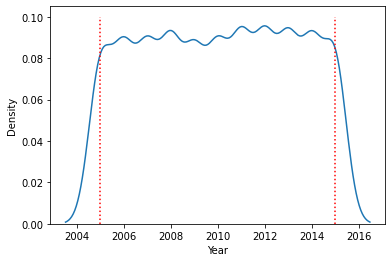

In [33]:
# It makes sense to look at the distribution of observations per year to understand if we have an evenly distributed sample.
sns.kdeplot(data=data, x='Year')
plt.vlines(2005, 0 , 0.1, linestyles='dotted', color = 'r')
plt.vlines(2015, 0 , 0.1, linestyles='dotted', color = 'r')

It seems as if our sample contains roughly the same yearly amount of kicks between 2005 - 2015.

In [34]:
# We use the same function as before but modify it to take into account years
# We use the same function as defined before.
kicker_list = data['Kicker'].unique()

def data_per_kicker(kickers):
    accuracies = []
    for i in kickers:
        # this is the dataframe for each kicker
        data_kicker = data.loc[(data['Kicker'] == i)]
        # For each kicker we only look at the shots they take that year
        years_played = data_kicker['Year'].unique()
        year = []
        for year in years_played:
            # this is the dataframe for each kicker for each year
            data_kicker_yearly = data_kicker.loc[(data['Year'] == year)]
            success = data_kicker_yearly['Success'].value_counts()
            if len(success) != 1:
                accuracy = success[1]/(success[1] + success[0])
                accuracies.append({'Year': year, 'Kicker' : i, 'Shots_taken': (success[1] + success[0]), 'Success': success[1], 'Accuracy' : accuracy})
            else:
                continue
    return accuracies

results = data_per_kicker(kicker_list)
frame_years = pd.DataFrame(results)
frame_years

,Year,Kicker,Shots_taken,Success,Accuracy
0,2005,Akers,22,16,0.727273
1,2006,Akers,27,22,0.814815
2,2007,Akers,32,24,0.750000
3,2008,Akers,50,42,0.840000
4,2009,Akers,37,32,0.864865
...,...,...,...,...,...
390,2015,Franks,16,13,0.812500
391,2015,Hocker,14,10,0.714286
392,2015,Hopkins,29,26,0.896552
393,2015,Lambo,32,26,0.812500


Since we can't plot all players. Let's create another table where we identify the players with the highest variance in accuracy(e.g. the least consistent) and those who have the lowest variance over the sample space.

For each kicker I calculate the variance $S^2 = \frac{\sum(x_i - \bar{x})^2}{n-1}$ where:
<ul>
    <li> $x_i$ = the value of the observation </li>
    <li> $\bar{x}$ = the mean value of all observations </li>
    <li> $n$ = the number of observations </li>
</ul>

In [35]:
# we can use the var() to do this for us by specifiying the column
kickers_names = frame_years['Kicker'].unique()
results_var = []
for name in kickers_names:
    data = frame_years.loc[frame_years['Kicker'] == name]
    var = data.var(numeric_only='Float')
    results_var.append({'Kicker': name, 'Variance': var['Accuracy']})
    
results_var = pd.DataFrame(results_var)
results_var = results_var.sort_values(ascending=False, by='Variance').dropna()
# these are the 5 highest variance players
results_var.head()

,Kicker,Variance
58,Henery,0.108169
44,Prater,0.043287
40,Gramatica,0.023802
48,Hauschka,0.021864
25,Novak,0.021560


In [36]:
# these have the lowest variance
results_var.tail()

,Kicker,Variance
18,Kaeding,0.000680
66,Catanzaro,0.000459
38,Andersen,0.000271
15,Hall,0.000014
71,Santos,0.000000


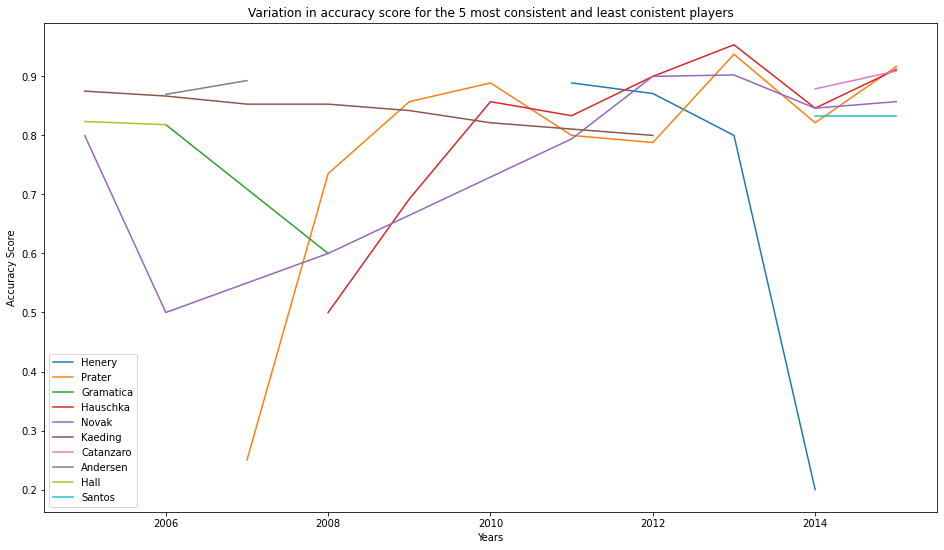

In [37]:
# Let's grab the first 5 kickers and last 5 kickers to plot
kickers = list(results_var['Kicker'].unique())
kickers = kickers[:5] + kickers[-5:] 

fig, axs = plt.subplots(1,1,figsize=(16,9))

for x in kickers:
    data = frame_years.loc[frame_years['Kicker'] == x]
    plt.plot(data['Year'], data['Accuracy'], label=f'{x}')
    plt.xlabel('Years')
    plt.ylabel('Accuracy Score')
    plt.title('Variation in accuracy score for the 5 most consistent and least conistent players')
    plt.legend()

Interestingly, we can observe that some players such as Hauschka improved thei kick accuracy year by year. This concludes question 9 part 2.

<hr>
<h1> Question 10</h1>
<p> 10.	Some argue that kickers get better with experience, in this dataset do you see evidence to support this conjecture? Try both a linear and quadratic specification. (For simplicity assume that there were no kicks attempted before the beginning of the dataset). What might be wrong with your estimates (besides incomplete data)? Explain! <p>

We can answer this question by looking at the accuracies over time and whether this increases as experience goes up.

In [38]:
# Let's compute experience in this dataset for each individual
frame_years['Exp'] = 0
names = frame_years['Kicker'].unique()
for i in names:
    frame_years.loc[(frame_years['Kicker'] == i), 'Exp'] = range(0, len(frame_years.loc[frame_years['Kicker'] == i]))


In [39]:
# Linear
data = frame_years.copy()
data['Intercept'] = 1
Y = data[['Accuracy']]
X = data[['Exp', 'Intercept']]
mod = sm.OLS(Y, X)
res = mod.fit(cov_type='HC2')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Accuracy   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     21.84
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           4.08e-06
Time:                        21:59:24   Log-Likelihood:                 342.44
No. Observations:                 395   AIC:                            -680.9
Df Residuals:                     393   BIC:                            -672.9
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Exp            0.0087      0.002      4.673      0.0

In [40]:
# Quadratic
# We need to use the Sklearn library for this
data = frame_years.copy()
data['Intercept'] = 1
Y = data[['Accuracy']]
X = np.array(data[['Exp']])
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X.reshape(-1, 1))
reg = LinearRegression(fit_intercept=True).fit(poly_features, Y)
print(reg.coef_[0])

[ 0.01711115 -0.00103364]


<strong> Answer: </strong> I find that as experience goes up the accuracy of the players goes up as well. This estimate is rather small but statistically significant. Our estimate could be wrong, since some players might have gotten injured and hence were excluded from the experience category, but still continued learning about their game.

<hr>
<h1> Question 11. </h1> <br>
What are the omitted variables you would want in this dataset? List at least 3 and which direction the bias of excluding them could go and why. 

I think it would be cool to look at factors such as age and also positional data. I know that there are datasets on Kaggle for example in the (NFL big data bowl competition) where movement(X, Y coordinates) as well as speed at relative times are recorded. I also think it would be interesting to see whether Kickers are better when their contracts are about to expire or whether that does not apply to Kickers. Excluding age could be a positive bias since, we could imagine that younger Kickers are more fit than older ones. On the other hand, we might discover that age is statistically insignificant.